# Retrieve track recommendations from Spotify

For each genre in our list, we retrieve 3 track recommendations from Spotify via Web API requests, along with track features provided by Spotify. We then clean the data, create a table in an existing database and copy the data to the table. The recommendation engine can then query this table for tracks to suggest to the user according to genre.

First we import the necessary libraries.

In [1]:
# Spotipy is a library for the Spotify Web API
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials

# Pandas to create dataframe and clean/transform data
import pandas as pd

# psycopg2 to interact with postgrsql db
import psycopg2

Request authorization from Spotify. Prior to that, an 'app' is created at the Spotify developer's site to obtain the Client ID and Client secret. This allows us to request for an access token via the Spotify API. More details here: https://developer.spotify.com/documentation/web-api/tutorials/getting-started

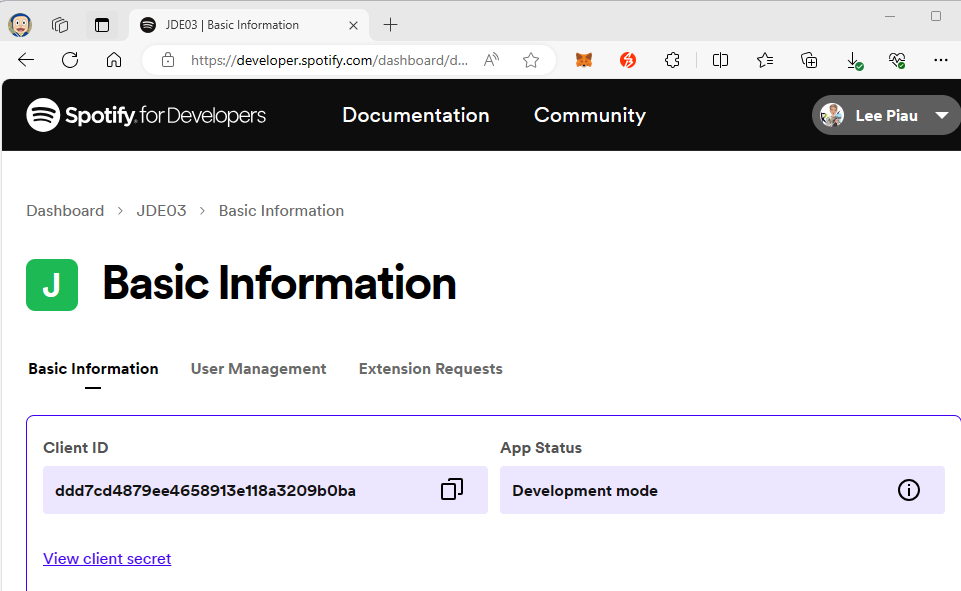

In [2]:
# Declare your Spotify API credentials
client_id = '6c2ff081fe494968a2e3a618c678fd62'
client_secret = '99da4179a82f4f999058535d8d9b47dc'

In [3]:
# Initialize the Spotipy client, 
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))

In [4]:
# Define seed genres
seed_genres = ['anime', 'ambient', 'classical', 'country', 'chill', 'edm', 'folk', 'gospel', 'hip-hop', 'jazz', 'k-pop', 'latin', 'metal', 'pop', 'r-n-b', 'rock', 'video-game-music', 'rap', 'lofi']

We now make a call to Spotify to get 3 track recommendations for each genre in our list defined above. We then request for track features (such as 'energy' and 'loudness') for each track that is recommended. We need to loop through the process for each genre. The data is returned in JSON and we extract the values that we need. 

In [5]:
# Initialize an empty list to store track data
all_track_data = []

In [6]:
# Call Spotify API to retrieve track data
for seed_genre in seed_genres:
    recommended_tracks = sp.recommendations(seed_genres=[seed_genre], limit=3, country="SG")
    for track in recommended_tracks["tracks"]:
        track_data = {
            "track_name": track["name"],
            "artist": ", ".join(artist["name"] for artist in track["artists"]),
            "album": track["album"]["name"],
            "genre": seed_genre,
            "image": track["album"]["images"][0]["url"],
            "preview_url": track["preview_url"],
            "url": track['album']['external_urls']['spotify']
        }
        all_track_data.append(track_data)
        
        # Search for individual track by ID to get "popularity".
        track_search = sp.track(track['id'])
        track_data["popularity"] = track_search["popularity"]

        # Search for audio features of track by ID
        audio_features = sp.audio_features(track['id'])[0]
        for key, value in audio_features.items():
            track_data[key] = value

Once we have the data in a list, we create a dataframe to inspect the data and perform necessary cleaning and transformation

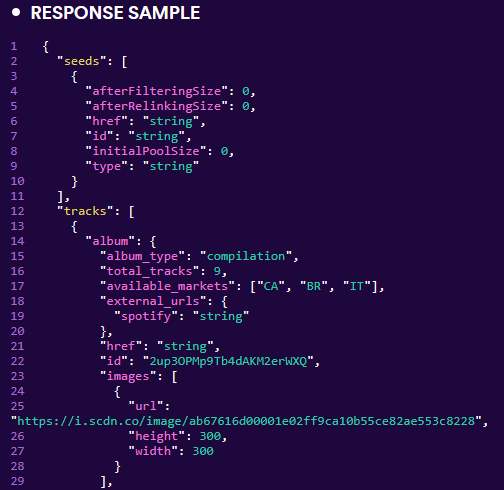

In [7]:
# Create a DataFrame from the track data
df = pd.DataFrame(all_track_data)

In [8]:
# Ensure print dataframe with full column width for url display
pd.set_option('display.max_colwidth', None)  

print(df.head(3))

  track_name       artist           album  genre  \
0       微熱の月  Luna Haruna         OVERSKY  anime   
1    Baby...        i☆Ris         Goin'on  anime   
2    prelude     Kalafina  THE BEST “Red”  anime   

                                                              image  \
0  https://i.scdn.co/image/ab67616d0000b273daecf6c1f858ffa935db3795   
1  https://i.scdn.co/image/ab67616d0000b273220355567de8715789c6c28c   
2  https://i.scdn.co/image/ab67616d0000b27378691a6b25ea64eb28b5302d   

                                                                                                   preview_url  \
0  https://p.scdn.co/mp3-preview/d93431e10f9ba7ed37a2987209d8e22edbb5d1a9?cid=6c2ff081fe494968a2e3a618c678fd62   
1  https://p.scdn.co/mp3-preview/af0409ec9ed6f6eab789c117a0c847e8046e2e8c?cid=6c2ff081fe494968a2e3a618c678fd62   
2  https://p.scdn.co/mp3-preview/665c0518c0db2df2dc004a380bdb55c2f88d9521?cid=6c2ff081fe494968a2e3a618c678fd62   

                                                 

In [9]:
# Pop 'id' column, and insert into the front, to designate as primary key in table
cols = list(df)
cols.insert(0, cols.pop(cols.index('id')))  
df = df[cols]

# Check after done
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                48 non-null     object 
 1   track_name        48 non-null     object 
 2   artist            48 non-null     object 
 3   album             48 non-null     object 
 4   genre             48 non-null     object 
 5   image             48 non-null     object 
 6   preview_url       39 non-null     object 
 7   url               48 non-null     object 
 8   popularity        48 non-null     int64  
 9   danceability      48 non-null     float64
 10  energy            48 non-null     float64
 11  key               48 non-null     int64  
 12  loudness          48 non-null     float64
 13  mode              48 non-null     int64  
 14  speechiness       48 non-null     float64
 15  acousticness      48 non-null     float64
 16  instrumentalness  48 non-null     float64
 17 

In [10]:
print(df['genre'].unique())

['anime' 'ambient' 'classical' 'country' 'chill' 'edm' 'folk' 'gospel'
 'hip-hop' 'jazz' 'k-pop' 'latin' 'metal' 'pop' 'r-n-b' 'rock']


In [11]:
# Check for duplicates
print(df[df.duplicated()])

Empty DataFrame
Columns: [id, track_name, artist, album, genre, image, preview_url, url, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, type, uri, track_href, analysis_url, duration_ms, time_signature]
Index: []

[0 rows x 26 columns]


In [12]:
# Drop 'type', 'uri', 'track_href', 'analysis_url', columns which are not needed
df.drop(columns=['type', 'uri', 'track_href', 'analysis_url'], inplace=True)
print(df.head(2))

                       id track_name       artist    album  genre  \
0  1rfcIM7xlZMNN2at8Rb4l1       微熱の月  Luna Haruna  OVERSKY  anime   
1  2AhigPDmN0Cb3DPMy7SDn1    Baby...        i☆Ris  Goin'on  anime   

                                                              image  \
0  https://i.scdn.co/image/ab67616d0000b273daecf6c1f858ffa935db3795   
1  https://i.scdn.co/image/ab67616d0000b273220355567de8715789c6c28c   

                                                                                                   preview_url  \
0  https://p.scdn.co/mp3-preview/d93431e10f9ba7ed37a2987209d8e22edbb5d1a9?cid=6c2ff081fe494968a2e3a618c678fd62   
1  https://p.scdn.co/mp3-preview/af0409ec9ed6f6eab789c117a0c847e8046e2e8c?cid=6c2ff081fe494968a2e3a618c678fd62   

                                                     url  popularity  \
0  https://open.spotify.com/album/5uw8YVzISyCjUPOqs2Dp4T          12   
1  https://open.spotify.com/album/5XzVuozdpCXrhiJNlPrFJl          12   

   danceability  .

Once satisfied with the data, we connect to the databse, create a table and insert data into the table

In [13]:
# Connect to PostgreSQL database
db_params = {
    "host": "rain.db.elephantsql.com",
    "dbname": "auspovuc",  
    "user": "auspovuc",  
    "password": "bmJdG19Daw9rkEsJ3VnkefRGCBF_oy7F"
}

conn = psycopg2.connect(**db_params)
cur = conn.cursor()

In [14]:
# Create a table recommended_tracks
cur.execute("""
    CREATE TABLE IF NOT EXISTS recommended_tracks (
        id VARCHAR PRIMARY KEY,
        track_name VARCHAR,
        artist VARCHAR,
        album VARCHAR,
        genre VARCHAR,
        image VARCHAR,
        preview_url VARCHAR,
        url VARCHAR,
        popularity SMALLINT,
        danceability FLOAT,
        energy FLOAT,
        key SMALLINT,
        loudness FLOAT,
        mode SMALLINT,
        speechiness FLOAT,
        acousticness FLOAT,
        liveness FLOAT, 
        valence FLOAT,
        tempo FLOAT,
        duration_ms INT,
        time_signature SMALLINT
    )
""")
conn.commit()

In [15]:
# # Insert data into the table
for _, row in df.iterrows():
    cur.execute("""
        INSERT INTO recommended_tracks (id, track_name, artist, album, genre, image, preview_url, url, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, liveness, valence, tempo, duration_ms, time_signature)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """, (row["id"], row["track_name"], row["artist"], row["album"], row["genre"], row["image"], row["preview_url"], row["url"], row["popularity"], row["danceability"], row["energy"], row["key"], row["loudness"], row["mode"], row["speechiness"], row["acousticness"], row["liveness"], row["valence"], row["tempo"], row["duration_ms"], row["time_signature"]))

conn.commit()

In [16]:
# Close connection
conn.close()

The table created in the database:
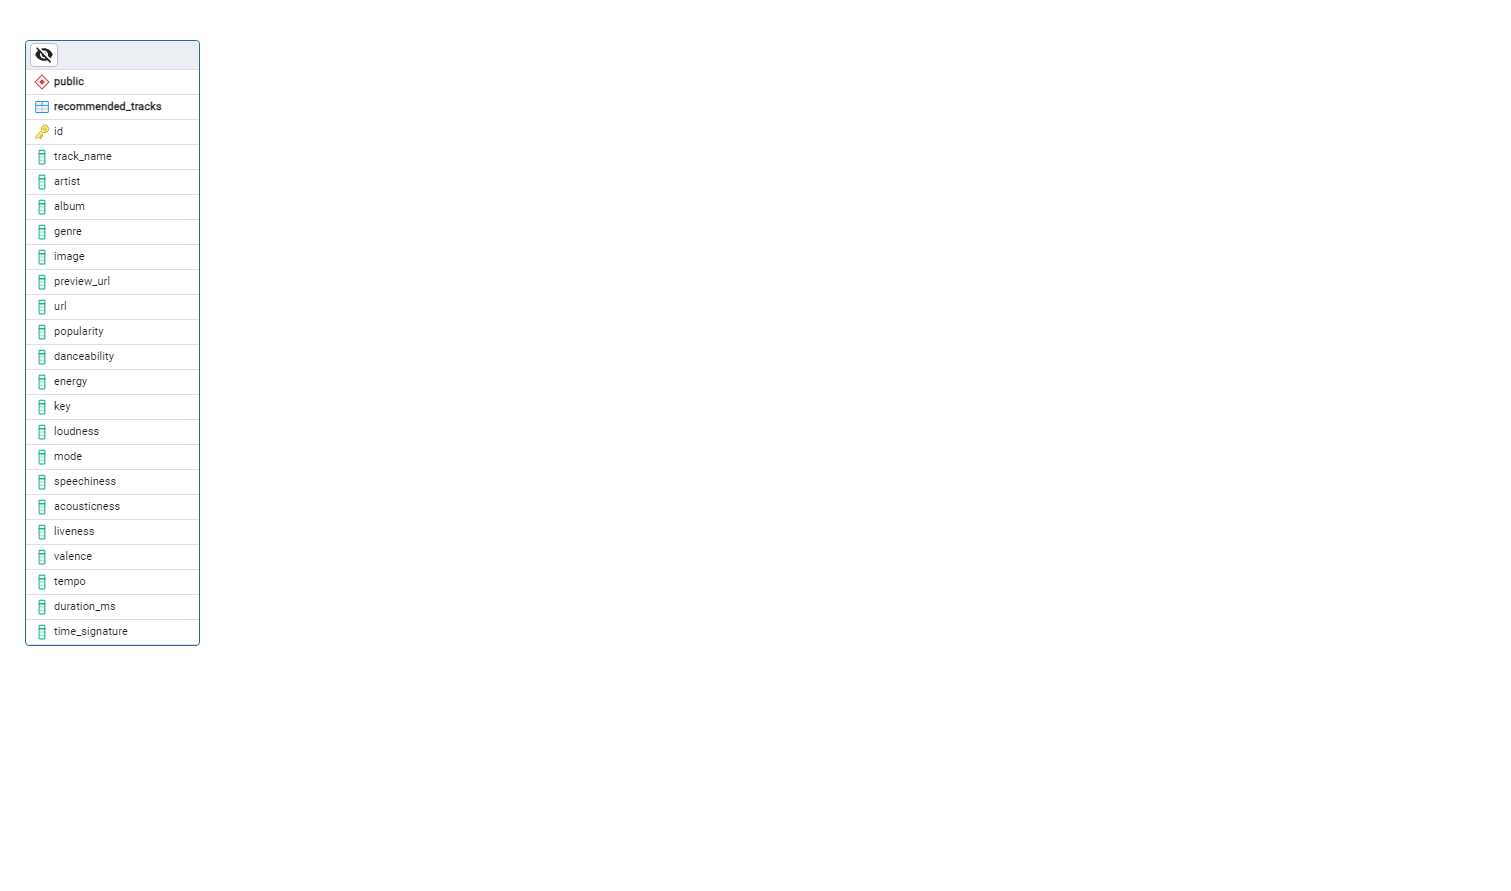